# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Подгружаем необходимые бибилиотеки и фиксируем псевдослучайную последовательность.

In [1]:
!pip install -U scikit-learn


import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

import time 

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor

state = 12345

Изучаем данные. Проверяем их на повторы, количество уникальных значений, распределение значений и удаляем полные дубликаты.

In [2]:
data = pd.read_csv('/datasets/autos.csv')
display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format="%Y/%m/%dT%H:%M:%S")
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format="%Y/%m/%dT%H:%M:%S")
display(data.info())
display(data.describe())
display(data.isna().sum())
display(data.nunique())
display(data.duplicated().sum())   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

DateCrawled          271174
Price                  3731
VehicleType               8
RegistrationYear        151
Gearbox                   2
Power                   712
Model                   250
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    40
Repaired                  2
DateCreated             109
NumberOfPictures          1
PostalCode             8143
LastSeen             179150
dtype: int64

4

В 5 столбцах есть довольно большое количество пропусков, которые необходимо будет обработать. Также очевидно, что есть много выбросов. Каждый столбец рассмотрим внимательнее по отдельности дилее. Сразу видно, что столбец с количеством фото полностью пустой, его можно удалить уже на данном этапе. Также проверим таблицу на мути-коллинеарность и посмотрим корреляцию между признаками.

In [4]:
data = data.drop_duplicates()
data.drop(['NumberOfPictures'], inplace=True, axis=1)
display(data.corr())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
Price,1.000000,0.026916,0.158872,-0.333207,0.110580,0.076058
RegistrationYear,0.026916,1.000000,-0.000828,-0.053448,-0.011619,-0.003459
Power,0.158872,-0.000828,1.000000,0.024006,0.043379,0.021662
Kilometer,-0.333207,-0.053448,0.024006,1.000000,0.009575,-0.007685
RegistrationMonth,0.110580,-0.011619,0.043379,0.009575,1.000000,0.013996
PostalCode,0.076058,-0.003459,0.021662,-0.007685,0.013996,1.000000


До обработки данных видно, что единственный признак, которые имеет видимуб корреляцию с ценой - это пробег. Сейчас показатель равен -0.33, что говорит о небольшой обратной зависимости и это логично: чем больше пробег - тем ниже цена.

Для обучения оставим только те признаки, которые могут влиять на стоимость автомобиля, это:
1. Тип кузова - автомобили с разными кузовами имеют разную стоимость
2. Год регистрации - вероятно, чем старше автомобиль - тем он дешевле. Однако, для очень старых и раритетных автомобилей существует обратная связь.
3. Коробка передач - предположим, что автомобиль на АКПП дороже, чем на МКПП
4. Мощность - как правило, более мощные автомобили стоят дороже
5. Модель 
6. Бренд - оба параметра необходимы для определения стоимости
7. Пробег - разъяснения есть выше
8. Тип топлива - вероятно, автомобиль одной и той же моели будет иметь разную стоимость в заивисимости от типа силовой установки
9. Поврежден ли автомобиль - очевидно, что после ДТП автомобиль будет дешевле

Таким образом, убраны следующие признаки:
1. Даты выгрузки, просмотра и создания объявлений 
2. Месяц регистрации - на стоимость влияет в основном год, а не месяц
3. Количество фото - везде их количество 0, вероятно проблема с выгрузкой данных
4. Почтовый индекс - он мало повлияет на стоимость в рамках одной страны, но его удаление ускорит обучение моделей

Проанализируем обновленную таблицу и рассмотрим каждый признак отдельно

In [5]:
new_data = data[['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
                 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired']]
display(new_data.info())
display(new_data.describe())
display(new_data.isna().sum())
display(new_data.nunique())
display(new_data.duplicated().sum())   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       316875 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           334532 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             334660 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          321470 non-null  object
 8   Brand             354365 non-null  object
 9   Repaired          283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


None

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

Price               3731
VehicleType            8
RegistrationYear     151
Gearbox                2
Power                712
Model                250
Kilometer             13
FuelType               7
Brand                 40
Repaired               2
dtype: int64

45036

Сперва рассмотрим количественные признакми. Цена. Это наш целевой признак. Построим гистограмму распределения цены, найдем количество уникальных значений и учитывая наличие значений, равных нулю, найдем 0.1 квантиль, чтобы отсечь объявления без цены, либо с крайне неправдоподобно низкой ценой.

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64
0.1    499.0
Name: Price, dtype: float64


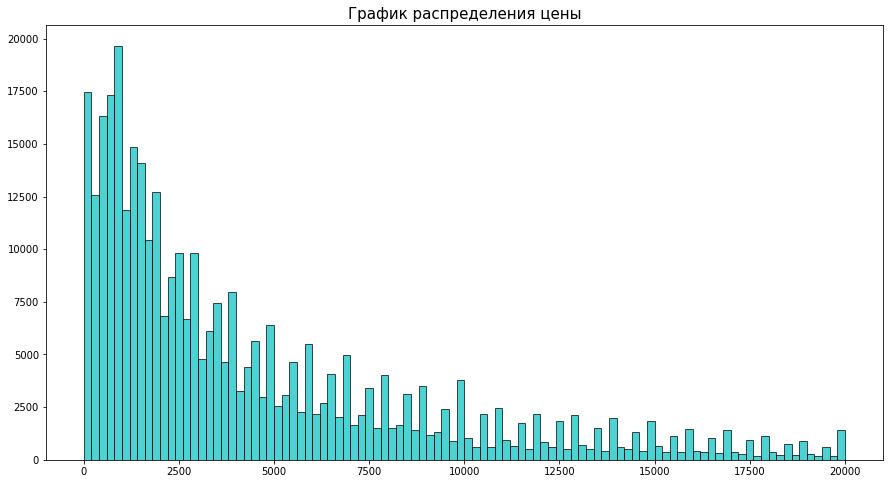

In [6]:
plt.figure(figsize=[15, 8])
plt.title('График распределения цены', fontsize=15)
plt.hist(new_data['Price'], bins=100, color = 'c', alpha = 0.7, ec='black');
print(new_data['Price'].value_counts())
print(new_data['Price'].quantile([0.1]))

Видно, что почти 11000 из 355000 не имеют цены. Это около 3% от выборки. 0.1 квантиль равен 499 евро. В целом, это соответствует цене дешевого европейского автомобиля. Удалим все объявления ниже этой цены.

count    318311.000000
mean       4895.114881
std        4520.278157
min         500.000000
25%        1499.000000
50%        3200.000000
75%        6950.000000
max       20000.000000
Name: Price, dtype: float64


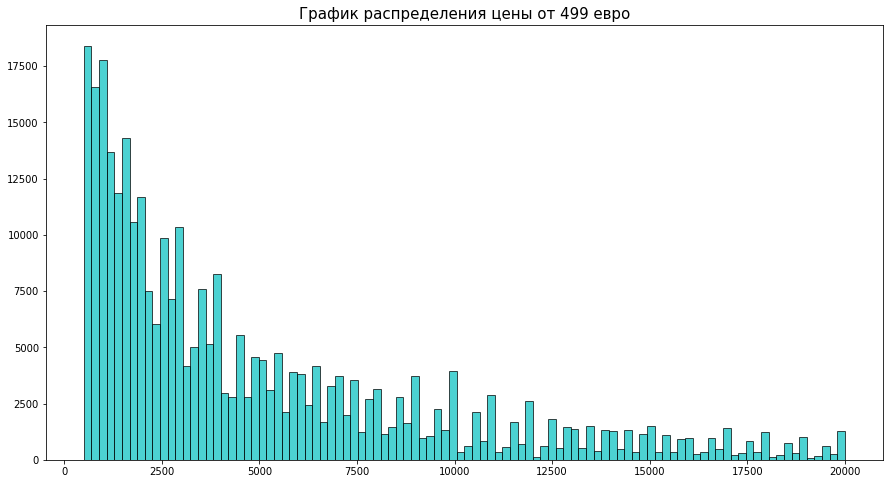

In [7]:
new_data = new_data.query('Price > 499')
plt.figure(figsize=[15, 8])
plt.title('График распределения цены от 499 евро', fontsize=15)
plt.hist(new_data['Price'], bins=100, color = 'c', alpha = 0.7, ec='black');
print(new_data['Price'].describe())

Очевидно, что чем выше цена - тем меньше обявлений. Средняя цена получилась 4895 евро за автомобиль, медианная - 3200 евро.

Год регистрации. Построим гистограмму, ограничим год с 1950 по 2023 на графике, найдем 0.01 квантиль.

count    318311.000000
mean       2004.164672
std          65.378165
min        1000.000000
25%        1999.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64
0.01    1980.0
Name: RegistrationYear, dtype: float64


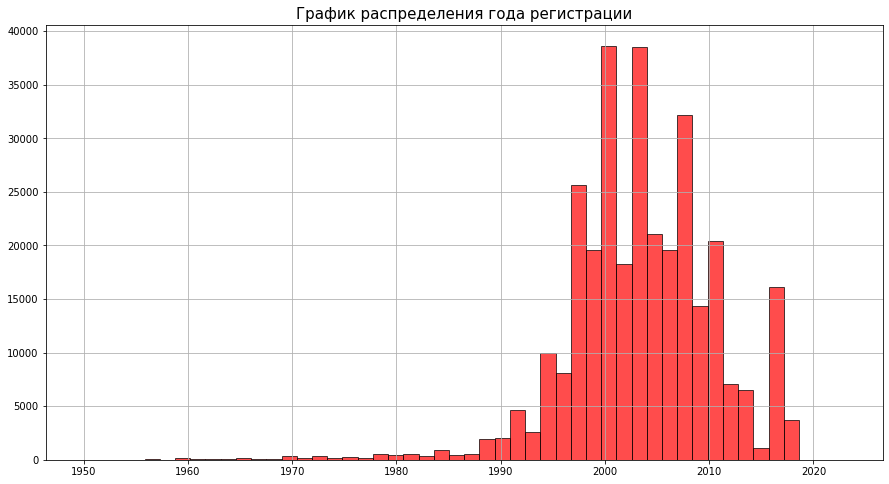

In [8]:
plt.title('График распределения года регистрации', fontsize=15)
new_data['RegistrationYear'].hist(bins=50, range=(1950, 2023), figsize=[15, 8], color = 'r', alpha = 0.7, ec='black')
print(new_data['RegistrationYear'].describe())
print(new_data['RegistrationYear'].quantile([0.01]))

Очевидно, что есть некорректные данные, как 9999 год, 65 год. 0.01 квантиль равен 1980, им и ограничим данные снизу, а сверху ограничим 2016 годом - последний год, когда был добавлен автомобиль в базу. Рассмотрим обновленные данные.

In [9]:
new_data = new_data.query('1980 <= RegistrationYear <= 2016')
print(new_data['RegistrationYear'].describe())

count    302308.000000
mean       2003.221066
std           5.882211
min        1980.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64


Видно, что самый новый втомобиль 2016 года. Средний год по таблице - 2003, медианный - 2003.

Мощность. Построим гистограмму, ограничим мощность от 0 до 700 на графике, найдем 0.1 и 0.99 квантиль.

count    302308.000000
mean        116.362475
std         185.537927
min           0.000000
25%          75.000000
50%         109.000000
75%         147.000000
max       20000.000000
Name: Power, dtype: float64
0.10     50.0
0.99    306.0
Name: Power, dtype: float64


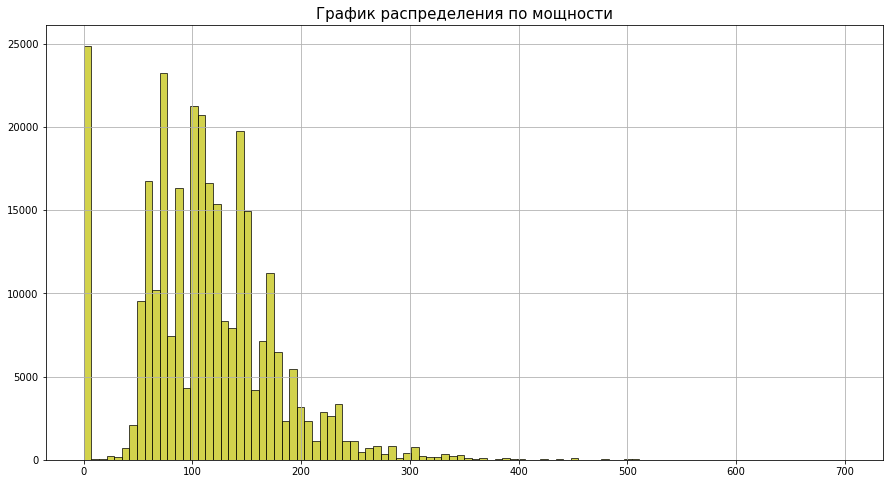

In [10]:
plt.title('График распределения по мощности', fontsize=15)
new_data['Power'].hist(bins=100, range=(0, 700), figsize=[15, 8], color = 'y', alpha = 0.7, ec='black')
print(new_data['Power'].describe())
print(new_data['Power'].quantile([0.1, 0.99]))

Видно, что большое количество автомобилей без указанной мощности. 0.1 квантиль - 50 л.с, 0.99 - 306 л.с. В целом, этот интервал соответсвует реальному рынку автомобилей. Им и ограничим данные в таблице. Основная часть распределена от 50 до 200 л.с.

In [11]:
new_data = new_data.query('50 <= Power <= 306')
print(new_data['Power'].describe())

count    271694.000000
mean        122.358550
std          48.884592
min          50.000000
25%          84.000000
50%         116.000000
75%         150.000000
max         306.000000
Name: Power, dtype: float64


Среднюю мощность получили 122 л.с., медианную 116 л.с.

Пробег. Построим гистограмму и посмотрим на данные.

count    271694.000000
mean     128053.527130
std       36618.195839
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64


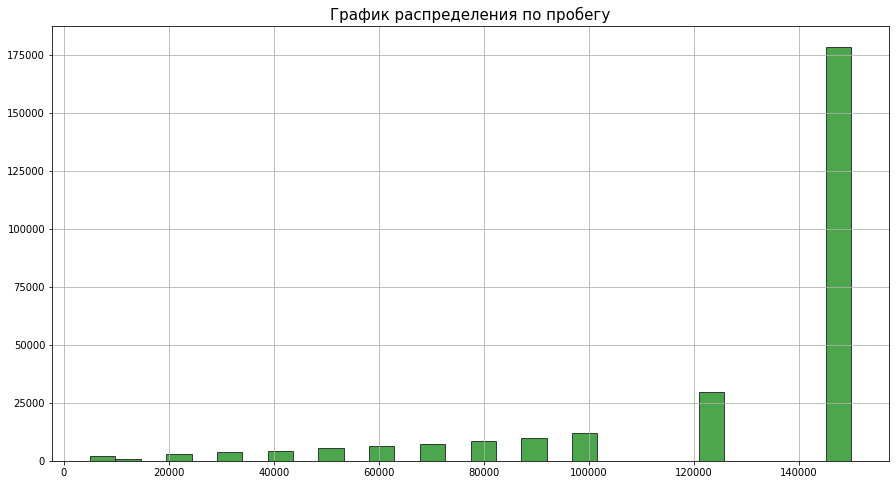

In [12]:
plt.title('График распределения по пробегу', fontsize=15)
new_data['Kilometer'].hist(bins=30, figsize=[15, 8], color = 'g', alpha = 0.7, ec='black')
print(new_data['Kilometer'].describe())

Видно, что очень большое количество автомобилей с пробегом ровно 150000 км. Вероятно, это обусловлено ограничением в форме подачи объявления или иными техническими причинами. В целом, пробег от 5000 до 150000 соответвует реальному рынку, столбец не требует изменений.

Теперь рассмторим качественные признаки. Тип кузова.

In [13]:
print(new_data['VehicleType'].value_counts())
print(new_data['VehicleType'].isna().sum())

sedan          78037
small          59806
wagon          56440
bus            25734
convertible    17878
coupe          13138
suv            10360
other           2096
Name: VehicleType, dtype: int64
8205


Видно, что есть 8 типов кузова, один из которых "другие". Популярнее всех седаны, компактные автомобили и универсалы(специфика европейского рынка). Много пропусков, около 5% всей выборки. Чтобы не удалять много данных, заполним пропуски значением "Неизвестно".

In [14]:
new_data['VehicleType'] = new_data['VehicleType'].fillna('unknown')
print(new_data['VehicleType'].value_counts())
print(new_data['VehicleType'].isna().sum())

sedan          78037
small          59806
wagon          56440
bus            25734
convertible    17878
coupe          13138
suv            10360
unknown         8205
other           2096
Name: VehicleType, dtype: int64
0


Коробка передач. 

In [15]:
print(new_data['Gearbox'].value_counts())
print(new_data['Gearbox'].isna().sum())
display(new_data.query('Gearbox.isna()'))

manual    212672
auto       54883
Name: Gearbox, dtype: int64
4139


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
151,6799,small,2009,NaN,60,NaN,20000,petrol,volkswagen,no
161,1495,wagon,2001,NaN,64,NaN,150000,gasoline,volkswagen,NaN
186,14000,sedan,2008,NaN,235,NaN,150000,NaN,bmw,no
233,3750,unknown,2005,NaN,75,golf,150000,NaN,volkswagen,NaN
276,2400,convertible,2001,NaN,115,golf,150000,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
353557,680,wagon,1998,NaN,120,passat,150000,petrol,volkswagen,NaN
353653,999,unknown,2016,NaN,125,a3,150000,NaN,audi,NaN
353664,2350,sedan,2002,NaN,75,golf,125000,NaN,volkswagen,NaN
353892,7900,bus,2009,NaN,140,NaN,125000,gasoline,sonstige_autos,no


In [16]:
new_data['Gearbox'] = new_data['Gearbox'].fillna('unknown')
print(new_data['Gearbox'].value_counts())

manual     212672
auto        54883
unknown      4139
Name: Gearbox, dtype: int64


Здесь также есть пропуски, заполним их тем же способом. В остальном, все КПП разделены на автоматические и механические. Механических в среднем в 4 раза больше.

Модель.

In [17]:
print(new_data['Model'].value_counts())
print(new_data['Model'].value_counts().count())
print(new_data['Model'].isna().sum())
display(new_data.query('Model.isna()'))

golf                  23062
other                 17685
3er                   16830
polo                   8728
a4                     8522
                      ...  
samara                    3
serie_2                   2
rangerover                2
range_rover_evoque        2
601                       1
Name: Model, Length: 248, dtype: int64
248
8829


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
135,1450,sedan,1992,manual,136,NaN,150000,NaN,audi,no
151,6799,small,2009,unknown,60,NaN,20000,petrol,volkswagen,no
161,1495,wagon,2001,unknown,64,NaN,150000,gasoline,volkswagen,NaN
186,14000,sedan,2008,unknown,235,NaN,150000,NaN,bmw,no
...,...,...,...,...,...,...,...,...,...,...
354062,6000,small,2008,manual,155,NaN,150000,petrol,sonstige_autos,no
354234,5000,sedan,2002,auto,170,NaN,150000,petrol,audi,no
354245,560,small,2001,auto,170,NaN,90000,petrol,fiat,yes
354321,9400,wagon,2007,manual,200,NaN,150000,gasoline,sonstige_autos,yes


Всего 248 моделей, самая популярная - Гольф. Также есть около 10000 пропусков. Их следует удалить, так как без модели сложно корректно рассчитать цену автомобиля.

In [18]:
new_data.dropna(subset=['Model'], inplace=True)
print(new_data['Model'].isna().sum())

0


Вид топлива.

In [19]:
print(new_data['FuelType'].value_counts())
print(new_data['FuelType'].isna().sum())

petrol      163532
gasoline     84336
lpg           4154
cng            450
hybrid         178
other           39
electric        27
Name: FuelType, dtype: int64
10149


Заполним пропуски "заглушкой". В целом, есть 7 видов силовых установок, но 2 категории наиболее популярны с большим отрывом.

In [20]:
new_data['FuelType'] = new_data['FuelType'].fillna('unknown')
print(new_data['FuelType'].value_counts())

petrol      163532
gasoline     84336
unknown      10149
lpg           4154
cng            450
hybrid         178
other           39
electric        27
Name: FuelType, dtype: int64


Бренд. 

In [21]:
print(new_data['Brand'].value_counts())
print(new_data['Brand'].isna().sum())

volkswagen       57330
bmw              29995
opel             27239
mercedes_benz    25740
audi             23733
ford             17720
renault          11946
peugeot           8243
fiat              6327
seat              5304
skoda             4780
mazda             4256
toyota            3863
citroen           3783
nissan            3596
smart             3511
hyundai           2905
mini              2895
volvo             2572
honda             2160
mitsubishi        2141
kia               1964
alfa_romeo        1762
suzuki            1739
chevrolet         1305
chrysler          1028
dacia              786
subaru             557
jeep               526
daihatsu           460
saab               439
land_rover         436
porsche            409
jaguar             384
daewoo             311
lancia             309
rover              273
lada               134
trabant              4
Name: Brand, dtype: int64
0


Здесь нет пропусков, корректировки не требуются. Самая популярная марка - фольксваген.

Повреждения. 

In [22]:
print(new_data['Repaired'].value_counts())
print(new_data['Repaired'].isna().sum())

no     208812
yes     21524
Name: Repaired, dtype: int64
32529


Здесь много пропусков, также заполним заглушкой. Авто либо повреждено, либо нет. Теперь будет еще вариант "неизвестно".

In [23]:
new_data['Repaired'] = new_data['Repaired'].fillna('unknown')
print(new_data['Repaired'].value_counts())

no         208812
unknown     32529
yes         21524
Name: Repaired, dtype: int64


Заново рассмотрим корреляцию числовых признаков.

In [24]:
display(new_data.corr())

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.587047,0.487865,-0.410645
RegistrationYear,0.587047,1.000000,0.101863,-0.407382
Power,0.487865,0.101863,1.000000,0.120368
Kilometer,-0.410645,-0.407382,0.120368,1.000000


После внесенных изменений, зависимость стала намного выраженнее по всем числовым признакам.

Далее переходим к обучению моделей.

## Обучение моделей

Разделим таблицу на признаки и целевые значения.

In [25]:
new_data=new_data.reset_index(drop=True)
features = new_data.drop('Price', axis=1)
target = new_data['Price']

Разделим данные на тренировочные и тестовые

In [26]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=state)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(210292, 9)
(52573, 9)
(210292,)
(52573,)


Нормализуем числовых признаки.

In [27]:
numeric=['RegistrationYear','Power','Kilometer']
scaler=StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric]=scaler.transform(features_train[numeric])
features_test[numeric]=scaler.transform(features_test[numeric])

display(features_train.head())
display(features_test.head())
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
73224,sedan,-0.602932,manual,-0.128958,beetle,0.602786,petrol,volkswagen,no
18269,convertible,-0.427582,manual,-0.252041,golf,0.602786,petrol,volkswagen,no
2332,wagon,-1.304332,manual,-0.149472,vectra,0.602786,petrol,opel,no
94198,small,-0.602932,manual,-0.662318,almera,0.602786,unknown,nissan,unknown
106827,coupe,-0.778282,manual,0.978791,3er,0.602786,petrol,bmw,no


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
2471,sedan,0.098468,manual,0.465945,mondeo,0.602786,petrol,ford,no
105070,bus,0.799869,auto,0.281320,b_klasse,-0.079903,petrol,mercedes_benz,no
172741,coupe,-2.882483,manual,-0.559749,scirocco,0.602786,petrol,volkswagen,no
179950,unknown,2.202669,auto,-1.277734,polo,0.602786,petrol,volkswagen,unknown
110040,small,-0.427582,manual,-0.128958,cooper,0.602786,petrol,mini,no


(210292, 9)
(52573, 9)
(210292,)
(52573,)


Отдельно возьмем качественные признаки и проведем прямое кодирование, которое улучшит работу моделей дерева, леса и пр.

In [28]:
col=['VehicleType', 'Gearbox', 'Model',
       'FuelType', 'Brand', 'Repaired']
encoder = OrdinalEncoder()
encoder.fit(features_train[col])
features_train_oe=features_train.copy()
features_train_oe[col]= pd.DataFrame(encoder.transform(features_train[col]), columns=encoder.feature_names_in_, index=features_train.index)
display(features_train_oe.head())
print(features_train_oe.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)
display(features_train.isna().sum())
display(features_train_oe.isna().sum())
print(features_train.columns)
print(features_train_oe.columns)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
73224,4.0,-0.602932,1.0,-0.128958,49.0,0.602786,6.0,37.0,0.0
18269,1.0,-0.427582,1.0,-0.252041,116.0,0.602786,6.0,37.0,0.0
2332,8.0,-1.304332,1.0,-0.149472,232.0,0.602786,6.0,24.0,0.0
94198,5.0,-0.602932,1.0,-0.662318,37.0,0.602786,7.0,23.0,1.0
106827,2.0,-0.778282,1.0,0.978791,11.0,0.602786,6.0,2.0,0.0


(210292, 9)
(52573, 9)
(210292,)
(52573,)


VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')
Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')


Также для модели линейной регрессии проведем "горячее" кодирование признаков OHE.

In [29]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)
for a in features_train.columns:
    if a not in features_test.columns:
        features_train = features_train.drop(a, axis=1)
display(features_train.head())
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
73224,-0.602932,-0.128958,0.602786,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
18269,-0.427582,-0.252041,0.602786,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2332,-1.304332,-0.149472,0.602786,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94198,-0.602932,-0.662318,0.602786,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
106827,-0.778282,0.978791,0.602786,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(210292, 301)
(52573, 301)
(210292,)
(52573,)


Напишем функцию вычисления rmse и на ее основе создадим скорер.

In [30]:
def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

Обучим модель линейной регрессии, такде зафиксируем время обучения и предсказания. Подсчитаем RMSE

In [31]:
%%time
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

CPU times: user 14.1 s, sys: 6.43 s, total: 20.5 s
Wall time: 20.8 s


LinearRegression()

In [32]:
%%time
predict_lr = model_lr.predict(features_test)
rmse_lr=mean_squared_error(target_test, predict_lr)**0.5
print(rmse_lr)

2328.813763678392
CPU times: user 80.9 ms, sys: 44 ms, total: 125 ms
Wall time: 118 ms


Получили RMSE 2328, время обучения 12 секунд, время предсказания 197 мс

Обучим модель дерева решений с перебором гиперпараметра глубины в цикле с помощью кросс-валидации. Используем закодированную OE выборку.

In [33]:
%%time
result_dt = 10000
param_dt = 0
for n in range(1, 10, 1):
    model_dt = DecisionTreeRegressor(max_depth=n, random_state=state)
    rmse_dt = cross_val_score(model_dt, features_train_oe, target_train, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
    final_rmse_dt = rmse_dt.mean()  
    final_rmse_dt = final_rmse_dt * (-1)
    if final_rmse_dt < result_dt:
        result_dt = final_rmse_dt
        param_dt = n
print(result_dt, param_dt)

1950.1437663828387 9
CPU times: user 7.56 s, sys: 88.2 ms, total: 7.65 s
Wall time: 7.71 s


Результат уже значительно лучше - 1950 при глубине 9. Общее время - 8 секунд. 

Обучим модель случайного леса с перебором гиперпараметров глубины и количества деревьев в цикле. Используем закодированную OE выборку.

In [34]:
%%time
result_rf = 10000
params_rf = []
for n in range(10, 31, 10):
    for i in range(1,11,2):
        model_rf = RandomForestRegressor(n_estimators=n, max_depth=i, random_state=state)
        rmse_rf = cross_val_score(model_rf, features_train_oe, target_train, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
        final_rmse_dt = rmse_rf.mean()
        final_rmse_dt = final_rmse_dt * (-1)
        if final_rmse_dt < result_rf:
            result_rf = final_rmse_dt
            params_rf = [n,i]
print(result_rf, params_rf)

1869.225161583566 [30, 9]
CPU times: user 2min 47s, sys: 677 ms, total: 2min 48s
Wall time: 2min 48s


Результат улучшился - 1869 при глубине 9 и 30 деревьях в лесу. Общее время - 2 минуты, 50 секунд.

Обучим модель CatBoost с перебором гиперпараметров с помощью GridSearchCV. Используем закодированную OE выборку.

In [35]:
%%time
model_cb = CatBoostRegressor()
params = {
        'n_estimators' : [10, 50, 100],
        'random_state' : [state],
        'max_depth' : [3, 7, 10],
        'learning_rate' : [0.3, 0.7] 
    }
search = GridSearchCV(model_cb, params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
search.fit(features_train_oe, target_train)
rmse_cb = (search.best_score_) * (-1)
print('Best params for CatBoost: ', search.best_params_)
print('Best RMSE for CatBoost', rmse_cb)

0:	learn: 3847.4256946	total: 70.8ms	remaining: 637ms
1:	learn: 3360.1246607	total: 89.3ms	remaining: 357ms
2:	learn: 3025.0021717	total: 109ms	remaining: 253ms
3:	learn: 2802.8113765	total: 128ms	remaining: 192ms
4:	learn: 2640.3735089	total: 149ms	remaining: 149ms
5:	learn: 2523.6476510	total: 168ms	remaining: 112ms
6:	learn: 2431.8037903	total: 186ms	remaining: 79.8ms
7:	learn: 2361.4226227	total: 206ms	remaining: 51.4ms
8:	learn: 2298.5662031	total: 226ms	remaining: 25.1ms
9:	learn: 2251.8622250	total: 245ms	remaining: 0us
0:	learn: 3836.8288045	total: 18.3ms	remaining: 165ms
1:	learn: 3353.1950524	total: 36.9ms	remaining: 148ms
2:	learn: 3018.3699847	total: 55.4ms	remaining: 129ms
3:	learn: 2805.2212452	total: 74.5ms	remaining: 112ms
4:	learn: 2615.2787672	total: 92.9ms	remaining: 92.9ms
5:	learn: 2510.1312558	total: 112ms	remaining: 74.9ms
6:	learn: 2418.1650715	total: 131ms	remaining: 56ms
7:	learn: 2352.3228056	total: 149ms	remaining: 37.3ms
8:	learn: 2293.5123458	total: 168ms	

Результат значительно улучшился до 1510, общее время вычислений 3 минуты 17 секунд.

Обучим модель LGBM с перебором гиперпараметров с помощью GridSearchCV. Используем закодированную OE выборку.

In [36]:
%%time
model_LGBM = LGBMRegressor() 
params = {
        'num_leaves':[30, 100],
        'random_state' : [state],
        'learning_rate' :[0.1, 0.9] 
    }
search = GridSearchCV(model_LGBM, params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
search.fit(features_train_oe, target_train)
rmse_LGBM = (search.best_score_) * (-1)
print('Best params: ', search.best_params_)
print('Best RMSE', rmse_LGBM)

Best params:  {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 12345}
Best RMSE 1510.1932337890648
CPU times: user 2min 2s, sys: 268 ms, total: 2min 2s
Wall time: 2min 3s


Результат практически не изменился и равен 1510, общее время вычислений немного ниже, 2 минуты 8 секунд.

## Анализ моделей

Проанализируем модели, рассмотрим отдельно время обучения и предсказания, лучшую модель проверим на тестовой выборке. Сначала модель дерева решений.

In [37]:
%%time
model_dt = DecisionTreeRegressor(max_depth=9, random_state=state)
model_dt.fit(features_train, target_train)

CPU times: user 3.42 s, sys: 210 ms, total: 3.63 s
Wall time: 3.69 s


DecisionTreeRegressor(max_depth=9, random_state=12345)

In [38]:
%%time
predict_dt = model_dt.predict(features_test)

CPU times: user 34.8 ms, sys: 53.6 ms, total: 88.4 ms
Wall time: 93.9 ms


Обучение заняло 3,64 секунды. Предсказание - 95 мс. Далее модель случайного леса.

In [39]:
%%time
model_rf = RandomForestRegressor(n_estimators=30, max_depth=9, random_state=state)
model_rf.fit(features_train_oe, target_train)

CPU times: user 6.95 s, sys: 36.7 ms, total: 6.99 s
Wall time: 7 s


RandomForestRegressor(max_depth=9, n_estimators=30, random_state=12345)

In [40]:
%%time
predict_rf = model_dt.predict(features_test)

CPU times: user 42.3 ms, sys: 42.3 ms, total: 84.6 ms
Wall time: 93.3 ms


Время обучения - 7 секунд, время предсказания - 92 мс. Далее модель Catboost.

In [41]:
%%time
model_cb = CatBoostRegressor(learning_rate=0.7, max_depth=10, n_estimators=100, random_state=state)
model_cb.fit(features_train, target_train)

0:	learn: 2614.2873925	total: 54.3ms	remaining: 5.38s
1:	learn: 2108.9909465	total: 109ms	remaining: 5.32s
2:	learn: 1908.0005475	total: 164ms	remaining: 5.3s
3:	learn: 1854.9504435	total: 217ms	remaining: 5.21s
4:	learn: 1800.9320162	total: 270ms	remaining: 5.13s
5:	learn: 1774.6147054	total: 329ms	remaining: 5.15s
6:	learn: 1735.0155737	total: 382ms	remaining: 5.07s
7:	learn: 1712.9313594	total: 437ms	remaining: 5.03s
8:	learn: 1701.7501566	total: 493ms	remaining: 4.98s
9:	learn: 1684.4645751	total: 550ms	remaining: 4.95s
10:	learn: 1662.2794089	total: 606ms	remaining: 4.9s
11:	learn: 1650.6928441	total: 665ms	remaining: 4.87s
12:	learn: 1641.4678798	total: 721ms	remaining: 4.82s
13:	learn: 1633.7258368	total: 777ms	remaining: 4.77s
14:	learn: 1624.1212460	total: 835ms	remaining: 4.73s
15:	learn: 1608.8456224	total: 893ms	remaining: 4.69s
16:	learn: 1598.4614190	total: 951ms	remaining: 4.64s
17:	learn: 1591.9022109	total: 1s	remaining: 4.58s
18:	learn: 1587.2251476	total: 1.06s	remai

In [42]:
%%time
predict_cb = model_cb.predict(features_test)

CPU times: user 70.4 ms, sys: 27 µs, total: 70.4 ms
Wall time: 68.7 ms


Время обучения - около 7 секунд, время предсказания 72 мс. Далее модель LGBM.

In [43]:
%%time
model_LGBM = LGBMRegressor() 
model_LGBM.fit(features_train, target_train)

CPU times: user 6.91 s, sys: 286 ms, total: 7.2 s
Wall time: 7.26 s


LGBMRegressor()

In [44]:
%%time
predict_LGBM = model_LGBM.predict(features_test)

CPU times: user 576 ms, sys: 51.5 ms, total: 627 ms
Wall time: 613 ms


Время обучения - около 6.6 секунд, время предсказания 610 мс.

In [49]:
index = ['LinearRegression',
         'DecisionTreeRegressor_OE',
         'RandomForestRegressor_OE',
         'CatBoostRegressor_OE',
         'LGBMRegressor_OE']
data = {'RMSE':[rmse_lr,
                            result_dt,
                            result_rf,
                            rmse_cb,
                            rmse_LGBM],
        'Время обучения':[29,
                                     3.64,
                                     7.18,
                                     7.17,
                                     6.59],
        'Время предсказания':[0.114,
                                          0.0947,
                                          0.0923,
                                          0.072,
                                          0.0610]}

scores_time = pd.DataFrame(data=data, index=index)
scores_time['Общее время'] = (scores_time['Время обучения'] + 
                                               scores_time['Время предсказания'])
display(scores_time)

,RMSE,Время обучения,Время предсказания,Общее время
LinearRegression,2328.813764,29.00,0.1140,29.1140
DecisionTreeRegressor_OE,1950.143766,3.64,0.0947,3.7347
RandomForestRegressor_OE,1869.225162,7.18,0.0923,7.2723
CatBoostRegressor_OE,1510.544293,7.17,0.0720,7.2420
LGBMRegressor_OE,1510.193234,6.59,0.0610,6.6510


Таким образом, 2 последние модели имеют лучшие из всех и очень близкие показатели качества и очень близкие показатели по времени. Рассчитаем метрику на тестовой выборке для обеих моделей.

In [46]:
rmse_final=mean_squared_error(target_test, predict_cb)**0.5
print(rmse_final)

1486.2666599292036


In [47]:
rmse_final_1=mean_squared_error(target_test, predict_LGBM)**0.5
print(rmse_final_1)

1582.9829243041236


RMSE на тестовой выборке значительно лучше у CatBoost. Ее и будем считать лучшей моделью.

## Итоги

1. Были изучены и проанализированы входные данные. Мы внесли изменения в датасет, рассмотрели распределение данных, убрали лишние данные, выбросы, применили разные виды кодирования данных.
2. Мы обучили 5 разных моделей с перебором гиперпараметров и кросс-валидацией, вычислили для каждой из них метрику качества RMSE и время обучения и предсказания.
3. С учетом требований заказчика, приоритетами которого являются низкий показатель RMSE и быстрое время обучения и предсказания, лучшей моделью быа выбрана CatBoostRegressor.
4. Требование к занчению метрики менее 2500 выполнено для всех 5 моделей из данного исследования.

# <font color='orange'>Рекомендации 🔥</font>
* Доступное объяснение про работу градиентного бустинга https://www.youtube.com/watch?v=ZNJ3lKyI-EY&t=995s
* После просмотра видео можешь почитать статью про ансамбли и бустинги https://habr.com/ru/company/ods/blog/645887/
* Подбор гиперпараметров для CatBoost https://habr.com/ru/company/otus/blog/527554/
* Подбор гиперпараметров для LightGBM https://programmersought.com/article/40776531516/
* Разумные способы кодирования категориальных данных для машинного обучения https://machinelearningmastery.ru/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159/
* Статья про "непонятную" метрику ROC-AUC https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
* Хочешь подтянуть математику для DS?) https://academy.stepik.org/math-for-data-science
* Результы обучения моделей можно визуализировать 😎 https://www.datatechnotes.com/2019/08/elasticnet-regression-example-in-python.html
* В нашем деле нужно быть всегда в курсе всех новинок, новостей и тд, вот тут публикуют новости в области DS: https://www.infoq.com/data-analysis/news/
* Всем аналитикам данных рекомендую книгу Даниела Канемана "Думай медленно, решай быстро"